In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import utils
from model import BadModel
from dataset import SwingDataset, augment, oversample

In [2]:
torch.__version__

'1.4.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = "data/"

In [6]:
shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]

In [7]:
use_oversampling = True

In [8]:
X_data, y_data = utils.load_data(path)

In [10]:
if use_oversampling:
    X_data, y_data = oversample(X_data, y_data)
    print(X_data.shape, y_data.shape)

(225, 6, 500) (225, 10)


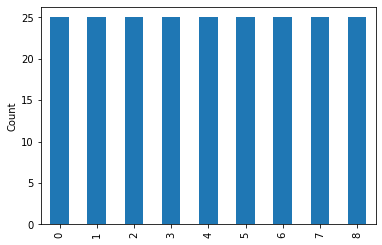

In [11]:
utils.plot_counts(y_data)

In [12]:
n = X_data.shape[0]

# GENERATE DATA SPLITS
train = 0.75
val = 0.2
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

In [13]:
X_train.shape, X_val.shape, X_test.shape

((168, 6, 500), (45, 6, 500), (11, 6, 500))

In [14]:
train_set = SwingDataset(X_train, y_train, augment=True)
val_set = SwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)

In [15]:
np.save("norm_data/X_mean.npy", train_set.mean)
np.save("norm_data/X_std.npy", train_set.std)
np.save("norm_data/y_mean.npy", train_set.y_dist_mean)
np.save("norm_data/y_std.npy", train_set.y_dist_std)

In [16]:
train_set.mean == np.load("norm_data/X_mean.npy")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

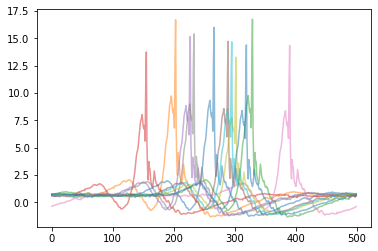

In [18]:
# test the data augmentation
plt.plot(train_set.X_data[0][0],alpha=0.5)
for _ in range(10):
    plt.plot(augment(train_set.X_data[0][0]), alpha=0.5)
plt.show()

In [20]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, drop_last=False, shuffle=True)

In [21]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel(5, 1, 3).to(device)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
va_losses = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
val_interval = 50
report_interval = 10

In [ ]:
loss_history = []
epochs = 100
for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
#     for data in tqdm(train_loader, desc=prefix):
    for data in train_loader:
        print(e, end="\r", flush=True)
        iter_idx += 1
        X_train, y = data
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_train.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss = swing_loss + dist_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if iter_idx % val_interval == 0:
            va_loss = []
            model = model.eval()
            for data in val_loader:
                X_va, y_va = data
                X_va = X_va.to(device)
                y_va = y_va.to(device)
                with torch.no_grad():
                    outputs_va = model(X_va.float())               
                    swing_loss = swing_type_loss(outputs_va[:, :-1], y_va[:, :-1])
                    dist_loss =  distance_loss(outputs_va[:, -1:], y_va[:, -1:])
                    loss = swing_loss + dist_loss
                    va_loss += [loss.cpu().numpy()]
                    
            model = model.train()
            va_loss = np.mean(va_loss)
            va_losses.append(va_loss)
            
            if va_loss < best_va_loss:
                best_va_loss = va_loss
                torch.save({
                    "iter_idx": iter_idx,
                    "best_va_loss": best_va_loss,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }, bestmodel_file)

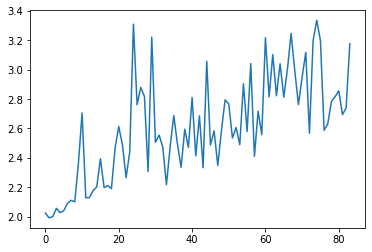

In [24]:
plt.plot(va_losses)

In [25]:
def print_preds(predictions, truth, mean, std):
    for pred, true in zip(predictions, truth):
        pred_distance = pred[-1] * std + mean
        pred_argmax = torch.argmax(pred[:-1])
        pred_shot_type = shot_types[pred_argmax]
        print(f"Pred: {pred_shot_type} {round(pred_distance.item())}yds")
        
        true_distance = true[-1] * std + mean
        true_argmax = torch.argmax(true[:-1])
        true_shot_type = shot_types[true_argmax]
        
        print(f"True: {true_shot_type} {round(true_distance.item())}yds")
        print()

In [26]:
print_preds(outputs, y, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Draw 129yds
True: Pull 145yds

Pred: Draw 136yds
True: Pull-hook 140yds

Pred: Fade 130yds
True: Push 140yds

Pred: Straight 46yds
True: Straight 20yds



In [27]:
print_preds(outputs_va, y_va, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Draw 137yds
True: Push-slice 115yds



# Test

In [28]:
# normalization moved to the dataloader
# X_test_norm = norm(X_test, train_mean, train_std)
# y_test_norm = y_test.copy()
# y_test_norm[:, -1] -= y_distance_mean
# y_test_norm[:, -1] /= y_distance_std

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, drop_last=False)

In [29]:
swing_losses, dist_losses, total_losses, = [], [], []
model = model.eval()
idx = 0

test_out = []
true_out = []
test_shot_types = []
true_shot_types = []

with torch.no_grad():
    for data in test_loader:
        idx += 1
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        outputs = model(x_test.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y_test[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y_test[:, -1:])
        total_loss = swing_loss + dist_loss
        
        swing_losses += [swing_loss.cpu().numpy()]
        dist_losses += [dist_loss.cpu().numpy()]
        total_losses += [total_loss.cpu().numpy()]
        
        print("Test example %d: swing_loss = %f, dist_loss = %f" % (idx, swing_losses[idx-1], dist_losses[idx-1]), end="\r", flush=True)
  
        test_out.append(outputs[0])
        true_out.append(y_test[0])
        test_shot_types.append(np.argmax(outputs[:, :-1]).item())
        true_shot_types.append(np.argmax(y_test[:, :-1]).item())
#         test_shot_dist.append(outputs[:,0].item())
#         true_shot_dist.append(y_test[:,0].item())
    
    avg_swing_loss = np.mean(swing_losses)
    avg_dist_loss = np.mean(dist_losses)
    avg_total_loss = np.mean(total_losses)
    print()
    print("Out of %d test examples: avg_swing_loss = %f, avg_dist_loss = %f, avg_total_loss = %f" % (idx, avg_swing_loss, avg_dist_loss, avg_total_loss))

Test example 11: swing_loss = 2.262498, dist_loss = 0.075621
Out of 11 test examples: avg_swing_loss = 2.235568, avg_dist_loss = 0.575452, avg_total_loss = 2.811020


In [30]:
print_preds(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Pull 80yds
True: Push-slice 70yds

Pred: Pull-hook 78yds
True: Push-slice 80yds

Pred: Straight 63yds
True: Push-slice 90yds

Pred: Pull-hook 87yds
True: Push-slice 60yds

Pred: Pull-hook 74yds
True: Push-slice 70yds

Pred: Pull-hook 127yds
True: Push-slice 130yds

Pred: Pull 124yds
True: Push-slice 70yds

Pred: Straight 62yds
True: Push-slice 90yds

Pred: Pull-hook 66yds
True: Push-slice 70yds

Pred: Pull-hook 86yds
True: Push-slice 70yds

Pred: Pull-hook 98yds
True: Push-slice 90yds



In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [1]:
cm = confusion_matrix(true_shot_types, test_shot_types)

NameError: name 'confusion_matrix' is not defined

In [2]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

NameError: name 'plt' is not defined